#  Image Colorization

Source of Research Paper : https://arxiv.org/pdf/1712.03400.pdf

As mentioned in Research paer, Model that is able to colorize images to a certain extent, combining a deep Convolutional Neural Network architecture and the latest released Inception model to this date, namely Inception-ResNet-v2, which is based on Inception v3 and Microsoft’s ResNet. While the deep CNN is trained from scratch, Inception-ResNet-v2 is used as a high-level feature extractor which provides information about the image contents that can help
their colorization.

This code is inspired from the given research paper. So it is not he excat implementation of it.

## Importing Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
import os
import scipy
import keras
import random
import cv2
from skimage.io import imread, imshow, imread_collection, concatenate_images
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import concatenate,Activation,Reshape,RepeatVector,MaxPooling2D
from tensorflow.keras.layers import Conv2D,Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import BatchNormalization
from PIL import Image, ImageFile
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## Importing Dataset

### Importing Dataset from Google Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
DatasetDirectory = os.getcwd() + '/My Drive/Epoch/Image Colorization'
os.chdir(DatasetDirectory)
print (os.getcwd())

/gdrive/My Drive/Epoch/Image Colorization


## Extracting and Visualisation Data

### Extracting Data

In [0]:
'''
Gray_Images = np.load('gray_scale.npy')[0:10000]
Images_Lab = np.zeros((10000,224,224,2))
Images_Lab[0:10000] = np.load('ab1.npy')[0:10000]
#Images_Lab[10000:] = np.load('ab2.npy')[0:5000]
#Images_Lab[20000:] = np.load('ab3.npy')
'''

"\nGray_Images = np.load('gray_scale.npy')[0:10000]\nImages_Lab = np.zeros((10000,224,224,2))\nImages_Lab[0:10000] = np.load('ab1.npy')[0:10000]\n#Images_Lab[10000:] = np.load('ab2.npy')[0:5000]\n#Images_Lab[20000:] = np.load('ab3.npy')\n"

In [0]:
path = DatasetDirectory + '/Images'
Images = os.listdir(path)
os.chdir(path)

Gray_Images = []
RGB_Images = []
Images_Lab = []
x = 0

for img in Images:
    if x%50 == 0:
        print ("{}% of Data Converted".format(x*100/len(Images)))
    try:
        img = imread(img)
        img = resize(img,(224,224))
        if len(img.shape) == 3:
            Gray_Images.append(img[:,:,0])
            RGB_Images.append(img)

            img = rgb2lab(img)
            Images_Lab.append(img[:,:,1:])
    except:
        print ("Failed to Convert, ", img)

    x = x+1

0.0% of Data Converted
1.0926573426573427% of Data Converted
2.1853146853146854% of Data Converted
3.277972027972028% of Data Converted
4.370629370629371% of Data Converted
5.463286713286713% of Data Converted
6.555944055944056% of Data Converted
7.648601398601398% of Data Converted
8.741258741258742% of Data Converted
9.833916083916083% of Data Converted
10.926573426573427% of Data Converted
12.01923076923077% of Data Converted
13.111888111888112% of Data Converted
14.204545454545455% of Data Converted
15.297202797202797% of Data Converted
16.38986013986014% of Data Converted
17.482517482517483% of Data Converted
18.575174825174827% of Data Converted
19.667832167832167% of Data Converted
20.76048951048951% of Data Converted
21.853146853146853% of Data Converted
22.945804195804197% of Data Converted
24.03846153846154% of Data Converted
25.13111888111888% of Data Converted
26.223776223776223% of Data Converted
27.316433566433567% of Data Converted
28.40909090909091% of Data Converted
29

In [0]:
Gray_Images = (np.array(Gray_Images) - np.mean(Gray_Images))/np.mean(Gray_Images)
RGB_Images = np.array(RGB_Images)
Images_Lab = (np.array(Images_Lab) - np.mean(Images_Lab))/np.mean(Images_Lab)

Gray_Images = Gray_Images.reshape(Gray_Images.shape+(1,))

print (Gray_Images.shape)

(4463, 224, 224, 1)


### Visualising Data

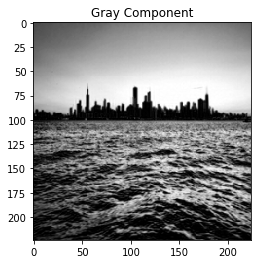

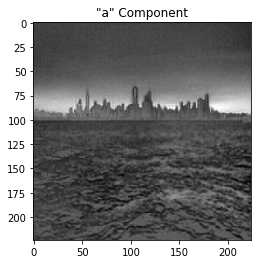

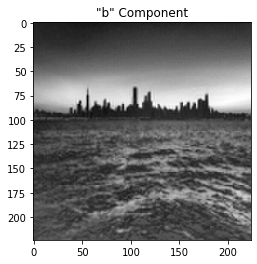

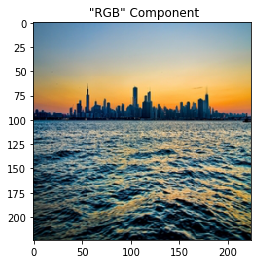

In [0]:
plt.imshow(Gray_Images[0,:,:,0],cmap='gray')
plt.title('Gray Component')
plt.show()

plt.imshow(Images_Lab[0,:,:,0],cmap='gray')
plt.title('"a" Component')
plt.show()

plt.imshow(Images_Lab[0,:,:,1],cmap='gray')
plt.title('"b" Component')
plt.show()

plt.imshow(RGB_Images[0])
plt.title(' "RGB" Component')
plt.show()

## Preprocessing Data

### InceptionResetV2 Module Function for Embeddings of Images

In [0]:
InceptionResNet = InceptionResNetV2(weights=None,include_top=True)
InceptionResNet.graph = tf.Graph()

In [0]:
def Embedded_Input(Batched_Images):

    Embed_Matrix = np.zeros((Batched_Images.shape[0],1000))
    i = 0
    for img in Batched_Images:
        if i%50 == 0:
            print ("{}% of Data Embedded".format(i*100/Batched_Images.shape[0]))
        x = preprocess_input(np.array([resize(img,(299,299,3))]))
        x = x.reshape(x.shape)
        Embed_Matrix[i] = InceptionResNet.predict(x)
        i = i+1

    return Embed_Matrix

### Image Augementation and Data Generators Functions

In [0]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

In [0]:
def Image_Data_Generator(Gray_Images,Images_Lab,Batch_Size=16):
    for X_Batch,Y_Batch in datagen.flow(Gray_Images,Images_Lab,batch_size=Batch_Size):
        X_Batch_RGB = gray2rgb(X_Batch[:,:,:,0])
        print (X_Batch_RGB.shape)
        Y_Batch = Y_Batch/128.0
        print (X_Batch.shape)
        yield [X_Batch,Embedded_Input(X_Batch_RGB),Y_Batch]

## Model and Architecture

![Architecture](https://github.com/baldassarreFe/deep-koalarization/blob/master/assets/our_net.png?raw=true)

The network is logically divided into four main components. The encoding
and the feature extraction components obtain mid and high-level features, respectively, which are then merged in the fusion layer. Finally, the decoder uses
these features to estimate the output.

### Creating Model

In [0]:
def Colorize_Model():
    # Clearing all Backend Models
    tf.keras.backend.clear_session()

    Embed_Input = Input(shape=(1000,))

    # Encoder Model
    Encoder_Input = Input(shape=(224,224,1))
    e = Conv2D(64, (3,3), activation='relu', padding='same',strides=2,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(Encoder_Input)
    e = Conv2D(128, (3,3), activation='relu', padding='same',strides=1,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    e = Conv2D(128, (3,3), activation='relu', padding='same',strides=2,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    e = Conv2D(256, (3,3), activation='relu', padding='same',strides=1,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    e = Conv2D(256, (3,3), activation='relu', padding='same',strides=2,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    e = Conv2D(512, (3,3), activation='relu', padding='same',strides=1,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    e = Conv2D(512, (3,3), activation='relu', padding='same',strides=1,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    Encoder_Output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(e)

    # Fusion Layer
    f = RepeatVector(28 * 28)(Embed_Input) 
    f = Reshape(([28, 28, 1000]))(f)
    f = concatenate([Encoder_Output, f], axis=3) 
    Fusion_Output = Conv2D(256, (1, 1), activation='relu', padding='same')(f)

    # Decoder Model
    d = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(Fusion_Output)
    d = UpSampling2D((2,2))(d)
    d = Conv2D(64, (3,3), activation='relu', padding='same',strides=1)(d)
    d = Conv2D(64, (3,3), activation='relu', padding='same',strides=1)(d)
    d = UpSampling2D((2,2))(d)
    d = Conv2D(32, (3,3), activation='relu', padding='same',strides=1)(d)
    d = Conv2D(2, (3,3), activation='relu', padding='same',strides=1)(d)
    Decoder_Output = UpSampling2D((2,2))(d)

    return Model(inputs=[Encoder_Input, Embed_Input], outputs=Decoder_Output)
    '''

    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(224, 224, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(28 * 28)(embed_input) 
    fusion_output = Reshape(([28, 28, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
    '''

In [0]:
def Colorize_Model_Revised():
    # Clearing all Backend Models
    tf.keras.backend.clear_session()

    Embed_Input = Input(shape=(1000,))

    # Encoder Model
    Encoder_Input = Input(shape=(224,224,1))
    e = Conv2D(64, (3,3), activation='relu', padding='same',strides=2,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(Encoder_Input)
    e = Conv2D(128, (3,3), activation='relu', padding='same',strides=1,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    e = Conv2D(128, (3,3), activation='relu', padding='same',strides=2,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    e = Conv2D(256, (3,3), activation='relu', padding='same',strides=1,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    e = Conv2D(256, (3,3), activation='relu', padding='same',strides=2,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    e = Conv2D(512, (3,3), activation='relu', padding='same',strides=1,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    e = Conv2D(512, (3,3), activation='relu', padding='same',strides=1,use_bias = True,bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05))(e)
    Encoder_Output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(e)

    # Fusion Layer
    f = RepeatVector(28 * 28)(Embed_Input) 
    f = Reshape(([28, 28, 1000]))(f)
    f = concatenate([Encoder_Output, f], axis=3) 
    Fusion_Output = Conv2D(256, (1, 1), activation='relu', padding='same')(f)

    # Decoder Model
    d = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(Fusion_Output)
    d = UpSampling2D((2,2))(d)
    d = Conv2D(64, (3,3), activation='relu', padding='same',strides=1)(d)
    d = Conv2D(64, (3,3), activation='relu', padding='same',strides=1)(d)
    d = UpSampling2D((2,2))(d)
    d = Conv2D(32, (3,3), activation='relu', padding='same',strides=1)(d)
    d = Conv2D(3, (3,3), activation='relu', padding='same',strides=1)(d)
    Decoder_Output = UpSampling2D((2,2))(d)

    return Model(inputs=[Encoder_Input, Embed_Input], outputs=Decoder_Output)

In [0]:
Model = Colorize_Model()
Model.compile(optimizer='adam', loss='mean_squared_error')
Model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 128 73856       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 56, 56, 128)  147584      conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
Model_Revised = Colorize_Model_Revised()
Model_Revised.compile(optimizer='adam', loss='mean_squared_error')
Model_Revised.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 128 73856       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 56, 56, 128)  147584      conv2d_1[0][0]                   
______________________________________________________________________________________________

## Training Model

In [0]:
# Set a Learning Rate Annealer
Learning_Rate_Reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "Model.h5"
Checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

Model_Callbacks = [Learning_Rate_Reduction,Checkpoint]

In [0]:
'''
Batch_Size = 2
Model.fit_generator(Image_Data_Generator(Gray_Images,Images_Lab,Batch_Size=Batch_Size), 
                    epochs=30,
                    steps_per_epoch = Gray_Images.shape[0]/Batch_Size
                    )
'''

'\nBatch_Size = 2\nModel.fit_generator(Image_Data_Generator(Gray_Images,Images_Lab,Batch_Size=Batch_Size), \n                    epochs=30,\n                    steps_per_epoch = Gray_Images.shape[0]/Batch_Size\n                    )\n'

In [0]:
print (Gray_Images.shape)
Embedded_Data = Embedded_Input(Gray_Images)
print (Embedded_Data.shape)

os.chdir(DatasetDirectory)

(4463, 224, 224, 1)
0.0% of Data Embedded
1.1203226529240422% of Data Embedded
2.2406453058480844% of Data Embedded
3.360967958772126% of Data Embedded
4.481290611696169% of Data Embedded
5.601613264620211% of Data Embedded
6.721935917544252% of Data Embedded
7.842258570468295% of Data Embedded
8.962581223392338% of Data Embedded
10.08290387631638% of Data Embedded
11.203226529240421% of Data Embedded
12.323549182164463% of Data Embedded
13.443871835088505% of Data Embedded
14.564194488012548% of Data Embedded
15.68451714093659% of Data Embedded
16.804839793860634% of Data Embedded
17.925162446784675% of Data Embedded
19.045485099708717% of Data Embedded
20.16580775263276% of Data Embedded
21.2861304055568% of Data Embedded
22.406453058480842% of Data Embedded
23.526775711404884% of Data Embedded
24.647098364328926% of Data Embedded
25.767421017252968% of Data Embedded
26.88774367017701% of Data Embedded
28.008066323101055% of Data Embedded
29.128388976025096% of Data Embedded
30.24871

In [0]:
Model.fit(x=[Gray_Images,Embedded_Data],y=Images_Lab,epochs=40,batch_size=256)

Train on 4463 samples
Epoch 1/20
4463/4463 [==============================] - 20s 5ms/sample - loss: 17.0386
Epoch 2/20
4463/4463 [==============================] - 20s 5ms/sample - loss: 16.9820
Epoch 3/20
4463/4463 [==============================] - 20s 5ms/sample - loss: 17.0132
Epoch 4/20
4463/4463 [==============================] - 20s 5ms/sample - loss: 16.9999
Epoch 5/20
4463/4463 [==============================] - 20s 5ms/sample - loss: 16.9955
Epoch 6/20
4463/4463 [==============================] - 20s 5ms/sample - loss: 16.9756
Epoch 7/20
4463/4463 [==============================] - 20s 5ms/sample - loss: 17.0525
Epoch 8/20
4463/4463 [==============================] - 20s 5ms/sample - loss: 16.9596
Epoch 9/20
4463/4463 [==============================] - 20s 5ms/sample - loss: 16.9605
Epoch 10/20
4463/4463 [==============================] - 20s 5ms/sample - loss: 16.8488
Epoch 11/20
4463/4463 [==============================] - 20s 5ms/sample - loss: 17.1267
Epoch 12/20
4463/44

In [0]:
Model_Revised.fit(x=[Gray_Images,Embedded_Data],y=RGB_Images,epochs=50,batch_size=32,verbose=1)

Train on 4463 samples
Epoch 1/50
4463/4463 [==============================] - 25s 6ms/sample - loss: 0.0783
Epoch 2/50
4463/4463 [==============================] - 22s 5ms/sample - loss: 0.0236
Epoch 3/50
4463/4463 [==============================] - 22s 5ms/sample - loss: 0.0225
Epoch 4/50
4463/4463 [==============================] - 22s 5ms/sample - loss: 0.0214
Epoch 5/50
4463/4463 [==============================] - 22s 5ms/sample - loss: 0.0208
Epoch 6/50
4463/4463 [==============================] - 22s 5ms/sample - loss: 0.0201
Epoch 7/50
4463/4463 [==============================] - 22s 5ms/sample - loss: 0.0195
Epoch 8/50
4463/4463 [==============================] - 22s 5ms/sample - loss: 0.0195
Epoch 9/50
4463/4463 [==============================] - 22s 5ms/sample - loss: 0.0191
Epoch 10/50
4463/4463 [==============================] - 22s 5ms/sample - loss: 0.0197
Epoch 11/50
4463/4463 [==============================] - 22s 5ms/sample - loss: 0.0186
Epoch 12/50
4463/4463 [=======

## Testing

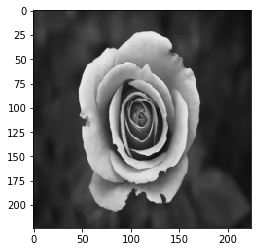

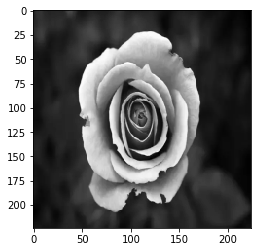

0.0% of Data Embedded


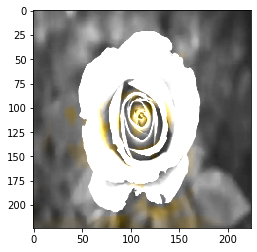

In [0]:
Model.save("Model_Research_Paper.h5")

Image = img_to_array((load_img('Rose.jpg')))
Image = resize(Image,(224,224,3))

plt.imshow(Image/255.0)
plt.show()

Image_Gray = Image[:,:,0]

plt.imshow(Image_Gray,cmap='gray')
plt.show()

Image_Gray_Extended = Image_Gray.reshape((1,)+Image_Gray.shape+(1,))
Embedded_Image = Embedded_Input(Image_Gray_Extended)

Prediction = Model.predict([Image_Gray_Extended,Embedded_Image])

P = np.zeros((224,224,3))
P[:,:,0] = Image_Gray
P[:,:,1:] = Prediction[0]

plt.imshow(lab2rgb(P))
plt.show()
imsave('Rose_Prediction_Research_Paper.jpg',P)

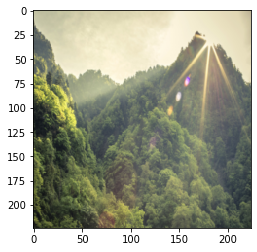

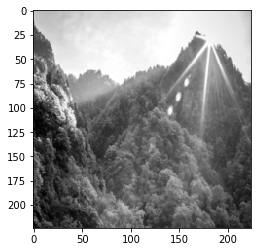

0.0% of Data Embedded


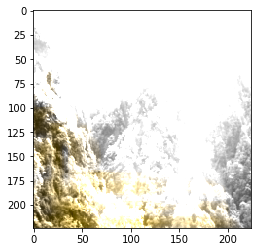

In [0]:
Image = img_to_array((load_img('Nature.jpg')))
Image = resize(Image,(224,224,3))

plt.imshow(Image/255.0)
plt.show()

Image_Gray = Image[:,:,0]

plt.imshow(Image_Gray,cmap='gray')
plt.show()

Image_Gray_Extended = Image_Gray.reshape((1,)+Image_Gray.shape+(1,))
Embedded_Image = Embedded_Input(Image_Gray_Extended)

Prediction = Model.predict([Image_Gray_Extended,Embedded_Image])

P = np.zeros((224,224,3))
P[:,:,0] = Image_Gray
P[:,:,1:] = Prediction[0]

plt.imshow(lab2rgb(P))
plt.show()
imsave('Nature_Prediction_Research_Paper.jpg',P)

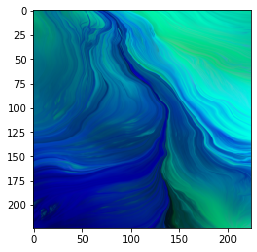

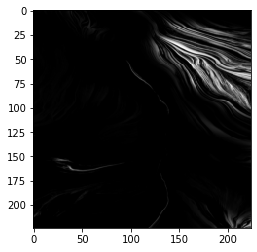

0.0% of Data Embedded


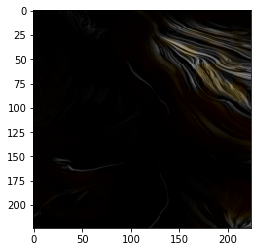

In [0]:
Image = img_to_array((load_img('Oppo.png')))
Image = resize(Image,(224,224,3))

plt.imshow(Image/255.0)
plt.show()

Image_Gray = Image[:,:,0]

plt.imshow(Image_Gray,cmap='gray')
plt.show()

Image_Gray_Extended = Image_Gray.reshape((1,)+Image_Gray.shape+(1,))
Embedded_Image = Embedded_Input(Image_Gray_Extended)

Prediction = Model.predict([Image_Gray_Extended,Embedded_Image])

P = np.zeros((224,224,3))
P[:,:,0] = Image_Gray
P[:,:,1:] = Prediction[0]

plt.imshow(lab2rgb(P))
plt.show()
imsave('Oppo_Prediction_Research_Paper.jpg',P)

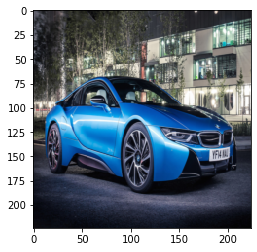

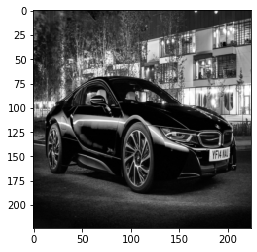

0.0% of Data Embedded


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1191 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


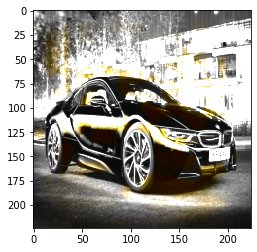

In [0]:
Image = img_to_array((load_img('BlueBMW.jpg')))
Image = resize(Image,(224,224,3))

plt.imshow(Image/255.0)
plt.show()

Image_Gray = Image[:,:,0]

plt.imshow(Image_Gray,cmap='gray')
plt.show()

Image_Gray_Extended = Image_Gray.reshape((1,)+Image_Gray.shape+(1,))
Embedded_Image = Embedded_Input(Image_Gray_Extended)

Prediction = Model.predict([Image_Gray_Extended,Embedded_Image])

P = np.zeros((224,224,3))
P[:,:,0] = Image_Gray
P[:,:,1:] = Prediction[0]

plt.imshow(lab2rgb(P))
plt.show()
imsave('BlueBMW_Prediction_Research_Paper.jpg',P)

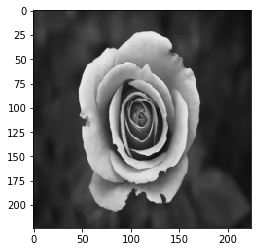

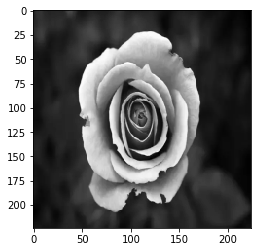

0.0% of Data Embedded


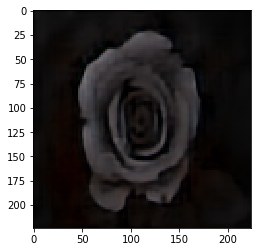

In [0]:
Model_Revised.save("Model_Research_Paper_Revised.h5")

Image = img_to_array((load_img('Rose.jpg')))
Image = resize(Image,(224,224,3))

plt.imshow(Image/255.0)
plt.show()

Image_Gray = Image[:,:,0]

plt.imshow(Image_Gray,cmap='gray')
plt.show()

Image_Gray_Extended = Image_Gray.reshape((1,)+Image_Gray.shape+(1,))
Embedded_Image = Embedded_Input(Image_Gray_Extended)

Prediction_Revisited = Model_Revised.predict([Image_Gray_Extended,Embedded_Image])

plt.imshow(Prediction_Revisited[0]/255.0)
plt.show()
imsave('Rose_Prediction_Research_Paper_Revised.jpg',Prediction_Revisited[0])

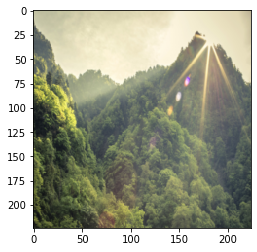

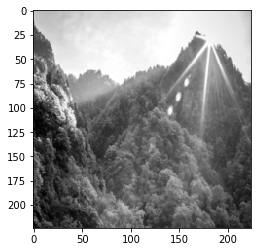

0.0% of Data Embedded


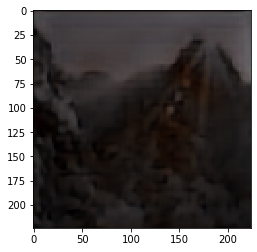

In [0]:
Image = img_to_array((load_img('Nature.jpg')))
Image = resize(Image,(224,224,3))

plt.imshow(Image/255.0)
plt.show()

Image_Gray = Image[:,:,0]

plt.imshow(Image_Gray,cmap='gray')
plt.show()

Image_Gray_Extended = Image_Gray.reshape((1,)+Image_Gray.shape+(1,))
Embedded_Image = Embedded_Input(Image_Gray_Extended)

Prediction_Revisited = Model_Revised.predict([Image_Gray_Extended,Embedded_Image])

plt.imshow(Prediction_Revisited[0]/255.0)
plt.show()
imsave('Nature_Prediction_Research_Paper_Revised.jpg',Prediction_Revisited[0])

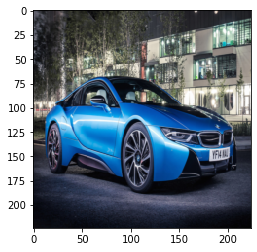

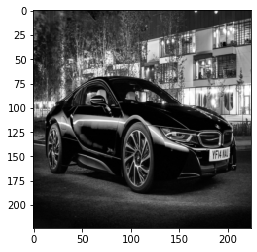

0.0% of Data Embedded


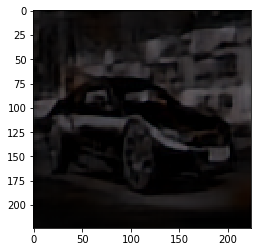

In [0]:
Image = img_to_array((load_img('BlueBMW.jpg')))
Image = resize(Image,(224,224,3))

plt.imshow(Image/255.0)
plt.show()

Image_Gray = Image[:,:,0]

plt.imshow(Image_Gray,cmap='gray')
plt.show()

Image_Gray_Extended = Image_Gray.reshape((1,)+Image_Gray.shape+(1,))
Embedded_Image = Embedded_Input(Image_Gray_Extended)

Prediction_Revisited = Model_Revised.predict([Image_Gray_Extended,Embedded_Image])

plt.imshow(Prediction_Revisited[0]/255.0)
plt.show()
imsave('BlueBMW_Prediction_Research_Paper_Revised.jpg',Prediction_Revisited[0])

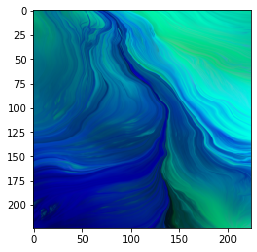

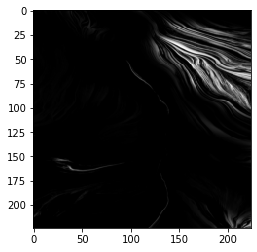

0.0% of Data Embedded


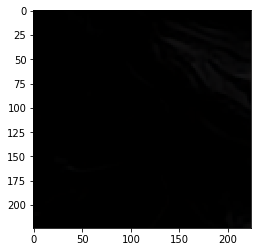

In [0]:
Image = img_to_array((load_img('Oppo.png')))
Image = resize(Image,(224,224,3))

plt.imshow(Image/255.0)
plt.show()

Image_Gray = Image[:,:,0]

plt.imshow(Image_Gray,cmap='gray')
plt.show()

Image_Gray_Extended = Image_Gray.reshape((1,)+Image_Gray.shape+(1,))
Embedded_Image = Embedded_Input(Image_Gray_Extended)

Prediction_Revisited = Model_Revised.predict([Image_Gray_Extended,Embedded_Image])

plt.imshow(Prediction_Revisited[0]/255.0)
plt.show()
imsave('Oppo_Prediction_Research_Paper_Revised.jpg',Prediction_Revisited[0])